In [9]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model

import keras.backend as K
from keras.models import Sequential

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [10]:
os.listdir("../input/")

['train.csv', 'train', 'test', 'sample_submission.csv']

In [11]:
train_df = pd.read_csv("../input/train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [12]:
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img("../input/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X_train

In [13]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

In [14]:
X = prepareImages(train_df, train_df.shape[0], "train")
X /= 255

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  04c72257b.jpg
Processing image:  1001 ,  09cacb84d.jpg
Processing image:  1501 ,  0ef961892.jpg
Processing image:  2001 ,  141b56a1a.jpg
Processing image:  2501 ,  199a417aa.jpg
Processing image:  3001 ,  1ec170983.jpg
Processing image:  3501 ,  23f084b93.jpg
Processing image:  4001 ,  29163ad0b.jpg
Processing image:  4501 ,  2e0fab120.jpg
Processing image:  5001 ,  3347515d9.jpg
Processing image:  5501 ,  3842d71dc.jpg
Processing image:  6001 ,  3d7f4c7d5.jpg
Processing image:  6501 ,  425f763ca.jpg
Processing image:  7001 ,  4714400cd.jpg
Processing image:  7501 ,  4c082fbdf.jpg
Processing image:  8001 ,  50c683e23.jpg
Processing image:  8501 ,  560d986ad.jpg
Processing image:  9001 ,  5b68c83ed.jpg
Processing image:  9501 ,  60410f111.jpg
Processing image:  10001 ,  654951f81.jpg
Processing image:  10501 ,  6a572256c.jpg
Processing image:  11001 ,  6f96f55b6.jpg
Processing image:  11501 ,  74da2b511.jpg

In [15]:
y, label_encoder = prepare_labels(train_df["Id"])

In [16]:
y.shape

(25361, 5005)

In [17]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [18]:
model = MobileNet(input_shape=(100, 100, 3), alpha=1., weights=None, classes=5005)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_5_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 101, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 50, 32)        128       
__________

In [19]:
history = model.fit(X, y, epochs=40, batch_size=50, verbose=1)

Epoch 1/40
25361/25361 [==============================] - 46s 2ms/step - loss: 6.2439 - categorical_crossentropy: 6.2439 - categorical_accuracy: 0.3790 - top_5_accuracy: 0.3882
Epoch 2/40
25361/25361 [==============================] - 39s 2ms/step - loss: 5.8804 - categorical_crossentropy: 5.8804 - categorical_accuracy: 0.3809 - top_5_accuracy: 0.3928
Epoch 3/40
25361/25361 [==============================] - 39s 2ms/step - loss: 5.7058 - categorical_crossentropy: 5.7058 - categorical_accuracy: 0.3811 - top_5_accuracy: 0.3911
Epoch 4/40
25361/25361 [==============================] - 38s 2ms/step - loss: 5.5634 - categorical_crossentropy: 5.5634 - categorical_accuracy: 0.3811 - top_5_accuracy: 0.3953
Epoch 5/40
25361/25361 [==============================] - 39s 2ms/step - loss: 5.4283 - categorical_crossentropy: 5.4283 - categorical_accuracy: 0.3811 - top_5_accuracy: 0.3976
Epoch 6/40
25361/25361 [==============================] - 38s 2ms/step - loss: 5.3044 - categorical_crossentropy: 5

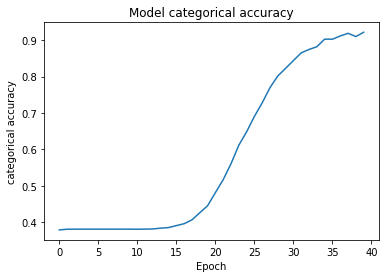

In [20]:
plt.plot(history.history['categorical_accuracy'])
plt.title('Model categorical accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('Epoch')
plt.show()

In [29]:
test = os.listdir("../input/test/")
print(len(test))

7960


In [22]:
col = ['Image']
test_df = pd.DataFrame(test, columns=col)
test_df['Id'] = ''

In [23]:
X = prepareImages(test_df, test_df.shape[0], "test")
X /= 255

Preparing images
Processing image:  1 ,  a2c423f5c.jpg
Processing image:  501 ,  d33369034.jpg
Processing image:  1001 ,  8f12dffcf.jpg
Processing image:  1501 ,  63edbfe95.jpg
Processing image:  2001 ,  45b6a301d.jpg
Processing image:  2501 ,  2e8009675.jpg
Processing image:  3001 ,  45108afa4.jpg
Processing image:  3501 ,  aae76f78c.jpg
Processing image:  4001 ,  f3c50eeeb.jpg
Processing image:  4501 ,  546907158.jpg
Processing image:  5001 ,  d08fd7c11.jpg
Processing image:  5501 ,  5765c6d62.jpg
Processing image:  6001 ,  7c66714ab.jpg
Processing image:  6501 ,  46fc45e4d.jpg
Processing image:  7001 ,  acc82bff3.jpg
Processing image:  7501 ,  e1dedc6bd.jpg


In [26]:
predictions = model.predict(np.array(X), verbose=1)

7960/7960 [==============================] - 3s 381us/step


In [27]:
for i, pred in enumerate(predictions):
    test_df.loc[i, 'Id'] = ' '.join(label_encoder.inverse_transform(pred.argsort()[-5:][::-1]))